# Zigzag Persistence Pipeline

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/Users/joshturner/Desktop/DrugOverdoseTDAVA/Data/VDHPUDOverdoseDeathsByYearAndGeographyLongLat.csv')


In [3]:
df.isna().sum()

Unnamed: 0                                      0
_id                                             0
Data Extract Date                               0
Overdose Death Year                          5896
Overdose Death Drug Class                       0
Overdose Death Geography Level                  0
Overdose Death FIPS                             0
Overdose Death Geography Name                   0
Overdose Death Health District                154
Overdose Death Count                          318
Overdose Death Rate per 100,000 Residents     384
County                                          0
Latitude                                      462
Longitude                                     462
dtype: int64

## Data Cleaning

In [7]:
df_cleaned = df.dropna(subset=[
    'Overdose Death Year', 
    'Latitude', 
    'Longitude', 
    'Overdose Death Count'
])


In [8]:
cols = [
    'Overdose Death Year', 
    'Latitude', 
    'Longitude', 
    'Overdose Death Count',
    'Overdose Death Rate per 100,000 Residents',
    'Overdose Death Drug Class',
    'Overdose Death Geography Name']

In [9]:
cols1 = [
    'Latitude', 
    'Longitude', 
    'Overdose Death Count',
    'Overdose Death Drug Class',
    'Overdose Death Geography Name']

In [10]:
# df_cleaned = df_cleaned[cols]
# df_cleaned = df_cleaned.dropna()
df_cleaned_19 = df_cleaned[cols]
df_cleaned_19 = df_cleaned_19[df_cleaned_19['Overdose Death Year'] == 2019]
df_cleaned_19 = df_cleaned_19[cols]
from sklearn.preprocessing import StandardScaler, LabelEncoder

# # Integer encode the string column
le = LabelEncoder()
df_cleaned_19['Overdose Death Drug Class'] = le.fit_transform(df_cleaned_19['Overdose Death Drug Class'])
df_cleaned_19['Overdose Death Geography Name'] = le.fit_transform(df_cleaned_19['Overdose Death Geography Name'])

# # Normalize the numerical features
scaler = StandardScaler()
# features_scaled = s
scaler.fit_transform(df_cleaned_19)
df_cleaned_19[cols1] = scaler.fit_transform(df_cleaned_19[cols1])
df_cleaned_19.shape


(2882, 7)

In [14]:
df_cleaned_19 = df_cleaned_19[cols1]
df_cleaned_19.shape

(2882, 5)

# Distance Function and Filtration

In [15]:
import numpy as np
import pandas as pd

# Encode drug classes
drug_class_to_index = {drug: idx for idx, drug in enumerate(df_cleaned_19['Overdose Death Drug Class'].unique())}
df_cleaned_19['Drug Index'] = df_cleaned_19['Overdose Death Drug Class'].map(drug_class_to_index)

# Create feature vectors
def row_to_feature_vector(row):
    return [
        row['Latitude'],
        row['Longitude'],
        # row['Overdose Death Year'],
        row['Overdose Death Count'],
        row['Drug Index']
    ]

features = np.array([row_to_feature_vector(row) for _, row in df_cleaned_19.iterrows()])

# Custom metric
def custom_distance(u, v, weights):
    d_spatial = np.sqrt((u[0] - v[0])**2 + (u[1] - v[1])**2)
    # d_year = abs(u[2] - v[2])
    d_death = abs(u[2] - v[2])
    d_drug = 0 if u[3] == v[3] else 1
    return (weights['spatial'] * d_spatial +
            # weights['year'] * d_year +
            weights['death'] * d_death +
            weights['drug'] * d_drug)

# Distance matrix
weights = {'spatial': 1.0,'death': 0.1, 'drug': 2.0}
# weights = {'spatial': 1.0, 'year': 0.5, 'death': 0.1, 'drug': 2.0}
n = len(features)
distance_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n):
        dist = custom_distance(features[i], features[j], weights)
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist

distance_matrix


array([[0.        , 2.45787357, 3.64556672, ..., 0.18960956, 4.49229958,
        2.49276679],
       [2.45787357, 0.        , 3.26994937, ..., 2.42769306, 4.10929159,
        0.30176992],
       [3.64556672, 3.26994937, 0.        , ..., 3.68474815, 4.20483288,
        3.52143036],
       ...,
       [0.18960956, 2.42769306, 3.68474815, ..., 0.        , 4.34781999,
        2.34732337],
       [4.49229958, 4.10929159, 4.20483288, ..., 4.34781999, 0.        ,
        4.00373044],
       [2.49276679, 0.30176992, 3.52143036, ..., 2.34732337, 4.00373044,
        0.        ]], shape=(2882, 2882))

In [16]:
distance_matrix.max()

np.float64(16.63042663025397)

In [27]:
import gudhi
rips_complex = gudhi.RipsComplex(distance_matrix=distance_matrix, max_edge_length=1)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)

# Get list of simplices and their filtration values
# simplices = [(list(simplex), filt_value) for simplex, filt_value in simplex_tree.get_filtration()]


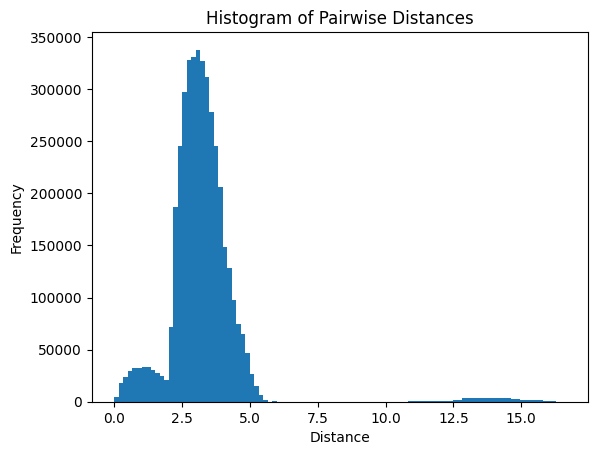

In [28]:
# for simplex, filt_value in simplex_tree.get_filtration():
#     print(simplex, filt_value)
import matplotlib.pyplot as plt

# Extract upper triangle distances
distances = distance_matrix[np.triu_indices(n, k=1)]
plt.hist(distances, bins=100)
plt.title("Histogram of Pairwise Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()


In [29]:
f = [simplex for simplex, filt in simplex_tree.get_filtration()]
times = [[filt] for simplex, filt in simplex_tree.get_filtration()]


In [30]:
import dionysus as d
import matplotlib.pyplot as plt
filtration = d.Filtration(f)
zz, dgms, cells = d.zigzag_homology_persistence(filtration, times)


In [31]:
zz

Zigzag persistence with 137751 alive cycles

In [32]:
def plot_barcode(dgm, dim):
    plt.figure(figsize=(10, 4))
    max_death = max(pt.death if pt.death != float('inf') else max([p.birth for p in dgm]) + 0.1 for pt in dgm)
    min_birth = min(pt.birth for pt in dgm)
    
    for i, pt in enumerate(dgm):
        b = pt.birth
        d = pt.death if pt.death != float('inf') else max_death + 0.1
        plt.hlines(y=i, xmin=b, xmax=d, colors='blue')
    
    plt.title(f"Zigzag Barcode: Dimension {dim}")
    plt.xlabel("Time")
    plt.ylabel("Interval")
    plt.ylim(-1, len(dgm))
    plt.xlim(min_birth - 0.1, max_death + 0.1)
    plt.grid(True)
    plt.show()


In [36]:
def plot_persistence_diagram(dgm, dim):
    plt.figure(figsize=(6,6))
    births = [pt.birth for pt in dgm]
    deaths = [pt.death if pt.death != float('inf') else max(births) + 0.5 for pt in dgm]
    
    plt.scatter(births, deaths, c='blue', alpha=0.6, edgecolors='k')
    max_val = max(deaths + births)
    plt.plot([0, max_val], [0, max_val], 'k--')  # diagonal line
    plt.xlabel('Birth')
    plt.ylabel('Death')
    plt.title(f'Persistence Diagram: Dimension {dim}')
    plt.xlim(0, max_val + 0.1)
    plt.ylim(0, max_val + 0.1)
    plt.grid(True)
    plt.show()


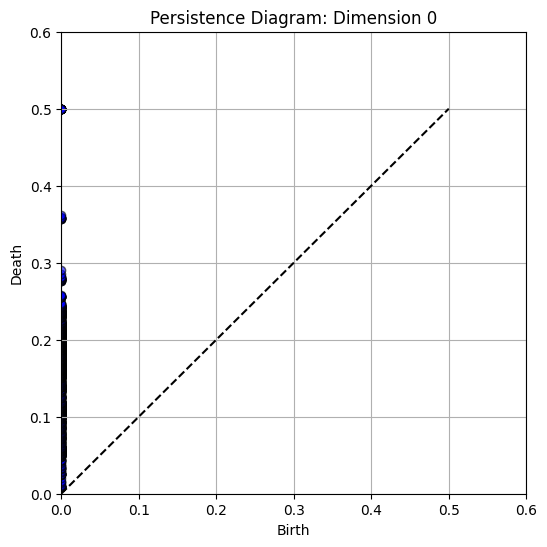

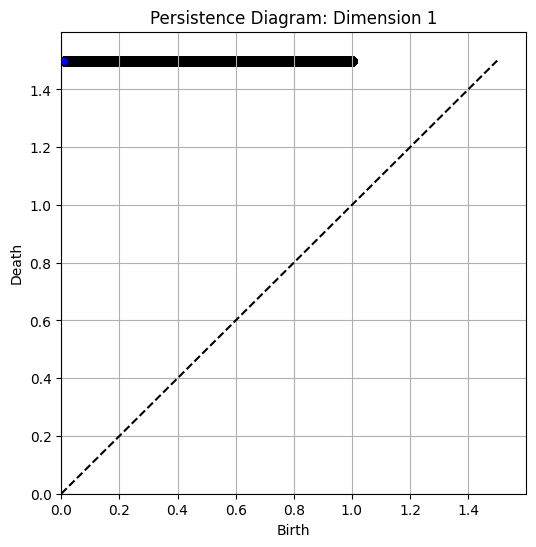

In [37]:
# l = enumerate(dgms)
for dim, dgm in enumerate(dgms):
    # print(f"Plotting for dimension {dim} ...")
    # plot_barcode(dgm, dim)
    plot_persistence_diagram(dgm, dim)


# End Zigzag 1

In [69]:
import dionysus as d
import numpy as np
import pandas as pd

# Your dataframe and distance matrix are assumed ready:
# df_cleaned, distance_matrix, features, weights

# Step 1: Separate indices by year
years = sorted(df_cleaned['Overdose Death Year'].unique())
year_indices = {year: df_cleaned.index[df_cleaned['Overdose Death Year'] == year].tolist() for year in years}

# Step 2: Build Rips complexes for each year using the corresponding sub-distance matrix
max_dim = 2  # up to edges and triangles
max_radius = 5  # tune this depending on your data scale

year_complexes = []
for year in years:
    idxs = year_indices[year]
    # Extract submatrix of distances for that year
    sub_dist = distance_matrix[np.ix_(idxs, idxs)]
    
    # Points for Dionysus need to be indexed vertices (integers 0..len(idxs)-1)
    # We'll use the sub_dist matrix directly to build Rips
    rips = d.fill_rips(sub_dist, max_dim=max_dim, max_radius=max_radius)
    year_complexes.append(rips)

# Step 3: Build zigzag filtration sequence
# We want something like: K_2019 -> K_2019∪2020 <- K_2020 -> K_2020∪2021 <- K_2021 -> ...

zigzag_complexes = []
zigzag_maps = []  # Maps between complexes (will be mostly inclusions)

def union_complex(complex1, complex2):
    """Build union complex simplices with correct indexing for zigzag"""
    # For simplicity, just merge the two sets of simplices and remove duplicates
    simplices = set(complex1) | set(complex2)
    # Dionysus expects a list of simplices sorted by dimension and filtration
    simplices = sorted(simplices, key=lambda s: (len(s), s))
    return simplices

def build_inclusion_map(source, target):
    """Build inclusion map from simplices in source complex to those in target complex"""
    source_dict = {s: i for i, s in enumerate(source)}
    target_dict = {s: i for i, s in enumerate(target)}
    # Map from source simplex indices to target simplex indices (or -1 if not present)
    return [target_dict.get(s, -1) for s in source]

# Start zigzag with the first year complex
zigzag_complexes.append(year_complexes[0])
zigzag_maps.append(None)  # No map for first

for i in range(len(year_complexes) - 1):
    # Union complex for two consecutive years
    union = union_complex(year_complexes[i], year_complexes[i+1])
    
    # Add union complex
    zigzag_complexes.append(union)
    # Map from previous year complex to union (inclusion)
    incl_map_1 = build_inclusion_map(year_complexes[i], union)
    zigzag_maps.append(incl_map_1)
    
    # Add next year complex
    zigzag_complexes.append(year_complexes[i+1])
    # Map from union back to next year complex (restriction)
    incl_map_2 = build_inclusion_map(union, year_complexes[i+1])
    zigzag_maps.append(incl_map_2)

# Step 4: Compute zigzag persistence
zigzag = d.zigzag_persistence(zigzag_complexes, zigzag_maps)

# Step 5: Extract intervals in H_0 and H_1
intervals_H0 = zigzag.intervals(0)
intervals_H1 = zigzag.intervals(1)

print("H_0 intervals:")
for interval in intervals_H0:
    print(interval)

print("\nH_1 intervals:")
for interval in intervals_H1:
    print(interval)


IndexError: index 14411 is out of bounds for axis 0 with size 14410

In [6]:
df_cleaned['Overdose Death Year'] = pd.to_numeric(df_cleaned['Overdose Death Year'], errors='coerce')
df_cleaned['Overdose Death Count'] = pd.to_numeric(df_cleaned['Overdose Death Count'], errors='coerce')
df_cleaned['Overdose Death Rate per 100,000 Residents'] = pd.to_numeric(
    df_cleaned['Overdose Death Rate per 100,000 Residents'], errors='coerce'
)

/var/folders/0l/vj8n1smx36d4lztxy5t6_zph0000gq/T/ipykernel_62452/1994122520.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Overdose Death Year'] = pd.to_numeric(df_cleaned['Overdose Death Year'], errors='coerce')
/var/folders/0l/vj8n1smx36d4lztxy5t6_zph0000gq/T/ipykernel_62452/1994122520.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Overdose Death Count'] = pd.to_numeric(df_cleaned['Overdose Death Count'], errors='coerce')
/var/folders/0l/vj8n1smx36d4lztxy5t6_zph0000gq/T/i

In [9]:
df_cleaned = df_cleaned.dropna(subset=['Overdose Death Year', 'Overdose Death Count'])

In [15]:
# Fill missing health districts
df_cleaned['Overdose Death Health District'] = df_cleaned['Overdose Death Health District'].fillna('Unknown')

# Optionally handle rate column
df_cleaned['Overdose Death Rate per 100,000 Residents'] = df_cleaned[
    'Overdose Death Rate per 100,000 Residents'
].fillna(-1)


In [16]:
df_cleaned.isna().sum()

Unnamed: 0                                   0
_id                                          0
Data Extract Date                            0
Overdose Death Year                          0
Overdose Death Drug Class                    0
Overdose Death Geography Level               0
Overdose Death FIPS                          0
Overdose Death Geography Name                0
Overdose Death Health District               0
Overdose Death Count                         0
Overdose Death Rate per 100,000 Residents    0
County                                       0
Latitude                                     0
Longitude                                    0
dtype: int64

## Subsetting by the Most Common Overdose Drugs

In [17]:
top_drugs = df_cleaned['Overdose Death Drug Class'].value_counts().head(3).index.tolist()
df_subset = df_cleaned[df_cleaned['Overdose Death Drug Class'].isin(top_drugs)]


In [21]:
df_subset.shape

(3948, 14)

## Aggregrate per County per Year per Drug Class

In [19]:
grouped = (
    df_subset.groupby(['County', 'Overdose Death Year', 'Overdose Death Drug Class'])
    .agg({
        'Overdose Death Count': 'sum',
        'Latitude': 'first',
        'Longitude': 'first'
    })
    .reset_index()
)

In [24]:
grouped.dtypes

County                        object
Overdose Death Year          float64
Overdose Death Drug Class     object
Overdose Death Count         float64
Latitude                     float64
Longitude                    float64
dtype: object

## Pipeline Plan
- Step 1: Represent the Data
We use each row as:
- A County
- A Year
- A Drug Class
Associated with:
- Death count
- Coordinates (Latitude, Longitude)

We build a point cloud where each drug class corresponds to a layer, and counties are nodes in that layer.


## Filtered Dataframe

In [49]:
df_small = df_cleaned[[
    'Overdose Death Year',
    'County',
    'Overdose Death Drug Class',
    'Overdose Death Count',
    'Latitude',
    'Longitude'
]].copy()

# Convert types
df_small['Overdose Death Year'] = df_small['Overdose Death Year'].astype(int)
df_small['Overdose Death Count'] = pd.to_numeric(df_small['Overdose Death Count'], errors='coerce').fillna(0).astype(int)

# Optional: Normalize county and drug names
df_small['County'] = df_small['County'].str.strip().str.title()
df_small['Overdose Death Drug Class'] = df_small['Overdose Death Drug Class'].str.strip().str.title()

# Drop remaining nulls
df_small.dropna(inplace=True)

# Confirm shape
df_small.shape


(14476, 6)

In [50]:
df_small['NodeID'] = df_small['County'] + "_" + df_small['Overdose Death Drug Class']
df_small = df_small.reset_index(drop=True)
node_to_index = {node: idx for idx, node in enumerate(df_small['NodeID'].unique())}


Filtration length: 103818
Times length: 2049828


AssertionError: Filtration and time lists must match


## Step 2: Construct Zigzag Filtration
You can think of this as a temporal multilayer network, where:
- Each layer is a year.
- Each point is a (drug class, county) pair.
Edges are formed:
- Between same counties across drug classes (pharmacological overlap)
- Between nearby counties with the same drug class (spatial correlation)
Possibly weighted by overdose death count
We add or remove simplices over time to capture:
- New drugs entering counties
- Disappearances of certain drug types
- Strong or weak co-occurrence patterns over time

In [28]:
# Build in Vertex IDs
# Each (County, Drug Class) pair is a node (0-simplex).
df_small['NodeID'] = df_small['County'] + "_" + df_small['Overdose Death Drug Class']
node_to_index = {node: idx for idx, node in enumerate(df_small['NodeID'].unique())}


In [30]:
# Step 3: Define Entry Times for Zigzag Filtration
# We'll build a list of:
# Simplices (nodes + edges)
# Times (when each enters the filtration)

In [31]:
import dionysus as d
from itertools import combinations
# Step 3a: Create vertex simplices with time
f = d.Filtration()
times = []
for _, row in df_small.iterrows():
    node = row['NodeID']
    idx = node_to_index[node]
    death_count = row['Overdose Death Count']
    year = row['Overdose Death Year']
    entry_time = 1.0 / (death_count + 1e-5)  # can be tweaked
    f.append(d.Simplex([idx]))
    times.append([entry_time])

In [34]:
# Step 4: Add Spatial or Pharmacological Edges
# We connect:
# Nodes in nearby counties with the same drug class
# Nodes in same county with different drug classes (co-exposure)

## Optimize Code Cell

## Step 3: Feature Map for Filtration Times
Options for entry time of simplices:
Feature	Meaning
- High overdose count → early entry	Drug class has large impact
- Late entry = emerging drug	Pharmacological shift
- Edge = co-occurrence or proximity	Temporal or spatial co-exposure

In [54]:
import dionysus as d
from itertools import combinations
from scipy.spatial.distance import pdist, squareform
import numpy as np

# Step 1: Create node_to_index map
node_to_index = {node: i for i, node in enumerate(df_small['NodeID'])}
row_pos = {idx: pos for pos, idx in enumerate(df_small.index)}  # For distance matrix indexing
node_to_index
# # Step 2: Compute spatial distance matrix
# coords = df_small[['Latitude', 'Longitude']].to_numpy()
# distance_matrix = squareform(pdist(coords))

# # Step 3: Initialize filtration and time list
# f = d.Filtration()
# times = []

# # Step 4: Add vertex simplices
# for _, row in df_small.iterrows():
#     node = row['NodeID']
#     idx = node_to_index[node]
#     death_count = row['Overdose Death Count']
#     entry_time = 1.0 / (death_count + 1e-5)
#     f.append(d.Simplex([idx]))
#     times.append([entry_time])

# # Step 5: Add spatial edges
# grouped_spatial = df_small.groupby(['Overdose Death Drug Class', 'Overdose Death Year'])
# for _, group in grouped_spatial:
#     indices = group.index.to_list()
#     for i, j in combinations(indices, 2):
#         if i not in row_pos or j not in row_pos:
#             continue  # safety check

#         node_i = df_small.loc[i, 'NodeID']
#         node_j = df_small.loc[j, 'NodeID']
#         idx_i = node_to_index[node_i]
#         idx_j = node_to_index[node_j]

#         if idx_i == idx_j:
#             continue

#         spatial_entry = distance_matrix[row_pos[i], row_pos[j]]
#         f.append(d.Simplex([idx_i, idx_j]))
#         times.append([spatial_entry])

# # Step 6: Add pharmacological co-exposure edges
# grouped_pharma = df_small.groupby(['County', 'Overdose Death Year'])
# for _, group in grouped_pharma:
#     indices = group.index.to_list()
#     for i, j in combinations(indices, 2):
#         drug_i = df_small.loc[i, 'Overdose Death Drug Class']
#         drug_j = df_small.loc[j, 'Overdose Death Drug Class']
#         if drug_i == drug_j:
#             continue

#         node_i = df_small.loc[i, 'NodeID']
#         node_j = df_small.loc[j, 'NodeID']
#         idx_i = node_to_index[node_i]
#         idx_j = node_to_index[node_j]

#         if idx_i == idx_j:
#             continue

#         f.append(d.Simplex([idx_i, idx_j]))
#         times.append([0.5])  # co-exposure edge

# # Final check
# print("Filtration length:", len(f))
# print("Times length:", len(times))
# assert len(f) == len(times), "Filtration and time lists must match"

# f.sort()


{'Southampton County_Any Opioids': 13702,
 'Prince Edward County_Benzodiazepine': 13706,
 'Martinsville City_Any Opioids': 13809,
 'Warren County_Benzodiazepine': 13810,
 'Poquoson City_Psychostimulant': 13711,
 'Madison County_Natural And Semi-Synthetic Opioids': 13818,
 'Essex County_Any Opioids': 13703,
 'Chesterfield County_Fentanyl And Other Synthetic Opioids': 13705,
 'Stafford County_Psychostimulant': 13712,
 'Williamsburg City_Methadone': 13812,
 'Nelson County_Psychostimulant': 13710,
 'Falls Church City_Cocaine': 13707,
 'Roanoke County_Cocaine': 13808,
 'York County_Benzodiazepine': 13708,
 'Richmond County_Methadone': 14266,
 'Northampton County_Methadone': 14268,
 'King George County_Methadone': 14263,
 'King And Queen County_Prescription Pain Relievers: Natural, Semi-Synthetic And Methadone': 14269,
 'Wythe County_Benzodiazepine': 14267,
 'Hampton City_Fentanyl And Other Synthetic Opioids': 14265,
 'Westmoreland County_Methadone': 14264,
 'Amherst County_Psychostimulant':